**Gender Voice Recognition**

In [1]:
import numpy as np 
import os 
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import missingno as msgn
import librosa
import argparse
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from scipy.interpolate import UnivariateSpline

In [2]:
dataframe = pd.read_csv('voice.csv')
dataframe.head()

,meanfreq,sd,median,Q25,Q75,IQR,skew,kurt,sp.ent,sfm,...,centroid,meanfun,minfun,maxfun,meandom,mindom,maxdom,dfrange,modindx,label
0,0.059781,0.064241,0.032027,0.015071,0.090193,0.075122,12.863462,274.402906,0.893369,0.491918,...,0.059781,0.084279,0.015702,0.275862,0.007812,0.007812,0.007812,0.000000,0.000000,male
1,0.066009,0.067310,0.040229,0.019414,0.092666,0.073252,22.423285,634.613855,0.892193,0.513724,...,0.066009,0.107937,0.015826,0.250000,0.009014,0.007812,0.054688,0.046875,0.052632,male
2,0.077316,0.083829,0.036718,0.008701,0.131908,0.123207,30.757155,1024.927705,0.846389,0.478905,...,0.077316,0.098706,0.015656,0.271186,0.007990,0.007812,0.015625,0.007812,0.046512,male
3,0.151228,0.072111,0.158011,0.096582,0.207955,0.111374,1.232831,4.177296,0.963322,0.727232,...,0.151228,0.088965,0.017798,0.250000,0.201497,0.007812,0.562500,0.554688,0.247119,male
4,0.135120,0.079146,0.124656,0.078720,0.206045,0.127325,1.101174,4.333713,0.971955,0.783568,...,0.135120,0.106398,0.016931,0.266667,0.712812,0.007812,5.484375,5.476562,0.208274,male


In [3]:
dataframe.isnull().sum()

meanfreq    0
sd          0
median      0
Q25         0
Q75         0
IQR         0
skew        0
kurt        0
sp.ent      0
sfm         0
mode        0
centroid    0
meanfun     0
minfun      0
maxfun      0
meandom     0
mindom      0
maxdom      0
dfrange     0
modindx     0
label       0
dtype: int64

*No missing values in the data*

In [4]:
print("data shape: ",dataframe.shape)

data shape:  (3168, 21)


In [6]:
dataframe.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3168 entries, 0 to 3167
Data columns (total 21 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   meanfreq  3168 non-null   float64
 1   sd        3168 non-null   float64
 2   median    3168 non-null   float64
 3   Q25       3168 non-null   float64
 4   Q75       3168 non-null   float64
 5   IQR       3168 non-null   float64
 6   skew      3168 non-null   float64
 7   kurt      3168 non-null   float64
 8   sp.ent    3168 non-null   float64
 9   sfm       3168 non-null   float64
 10  mode      3168 non-null   float64
 11  centroid  3168 non-null   float64
 12  meanfun   3168 non-null   float64
 13  minfun    3168 non-null   float64
 14  maxfun    3168 non-null   float64
 15  meandom   3168 non-null   float64
 16  mindom    3168 non-null   float64
 17  maxdom    3168 non-null   float64
 18  dfrange   3168 non-null   float64
 19  modindx   3168 non-null   float64
 20  label     3168 non-null   obje

In [9]:
print("label: ",dataframe['label'].unique())

label:  ['male' 'female']


In [10]:
# Convert the 'label' column to numerical values: 'male' -> 0, 'female' -> 1
dataframe['label'] = dataframe['label'].map({'male': 0, 'female': 1})

<Axes: >

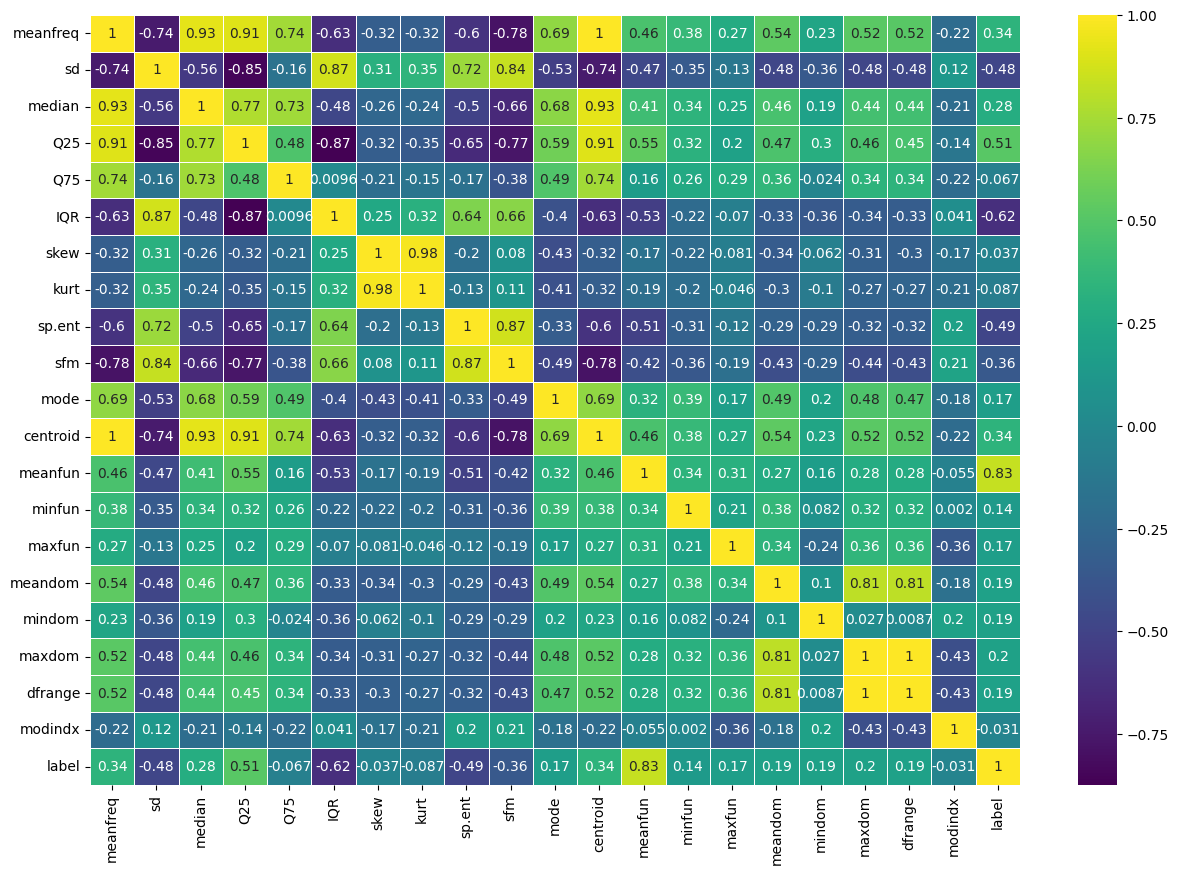

In [11]:
plt.figure(figsize=(15,10),dpi=100)
sns.heatmap(dataframe.corr(),cmap="viridis",annot=True,linewidth=0.5)

In [12]:
# Define the target variable and features
X = dataframe.drop('label', axis=1)
y = dataframe['label']

In [13]:
# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

In [14]:
# Print the shapes of the training and validation sets
print(f"Training set shape: {X_train.shape}")
print(f"Validation set shape: {X_val.shape}")

Training set shape: (2534, 20)
Validation set shape: (634, 20)


In [15]:
model = Sequential()
model.add(Dense(256, input_shape=(X_train.shape[1],)))
model.add(Dropout(0.3))
model.add(Dense(256, activation="relu"))
model.add(Dropout(0.3))
model.add(Dense(128, activation="relu"))
model.add(Dropout(0.3))
model.add(Dense(128, activation="relu"))
model.add(Dropout(0.3))
model.add(Dense(64, activation="relu"))
model.add(Dropout(0.3))
    
model.add(Dense(1, activation="sigmoid"))
   
model.compile(loss="binary_crossentropy", metrics=["accuracy"], optimizer="adam")
    
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 256)               5376      
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 256)               65792     
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 dense_2 (Dense)             (None, 128)               32896     
                                                                 
 dropout_2 (Dropout)         (None, 128)               0         
                                                                 
 dense_3 (Dense)             (None, 128)               1

In [16]:
# Train the model
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_val, y_val))

Epoch 1/50
80/80 [==============================] - 1s 4ms/step - loss: 1.1834 - accuracy: 0.5051 - val_loss: 0.6925 - val_accuracy: 0.4685
Epoch 2/50
80/80 [==============================] - 0s 3ms/step - loss: 1.0807 - accuracy: 0.5075 - val_loss: 0.6980 - val_accuracy: 0.4685
Epoch 3/50
80/80 [==============================] - 0s 2ms/step - loss: 0.9552 - accuracy: 0.4925 - val_loss: 0.7671 - val_accuracy: 0.4921
Epoch 4/50
80/80 [==============================] - 0s 2ms/step - loss: 0.8820 - accuracy: 0.4582 - val_loss: 0.6873 - val_accuracy: 0.4858
Epoch 5/50
80/80 [==============================] - 0s 3ms/step - loss: 0.7907 - accuracy: 0.4862 - val_loss: 0.6921 - val_accuracy: 0.4890
Epoch 6/50
80/80 [==============================] - 0s 3ms/step - loss: 0.7666 - accuracy: 0.5107 - val_loss: 0.6891 - val_accuracy: 0.4968
Epoch 7/50
80/80 [==============================] - 0s 2ms/step - loss: 0.7424 - accuracy: 0.5024 - val_loss: 0.6817 - val_accuracy: 0.5000
Epoch 8/50
80/80 [==

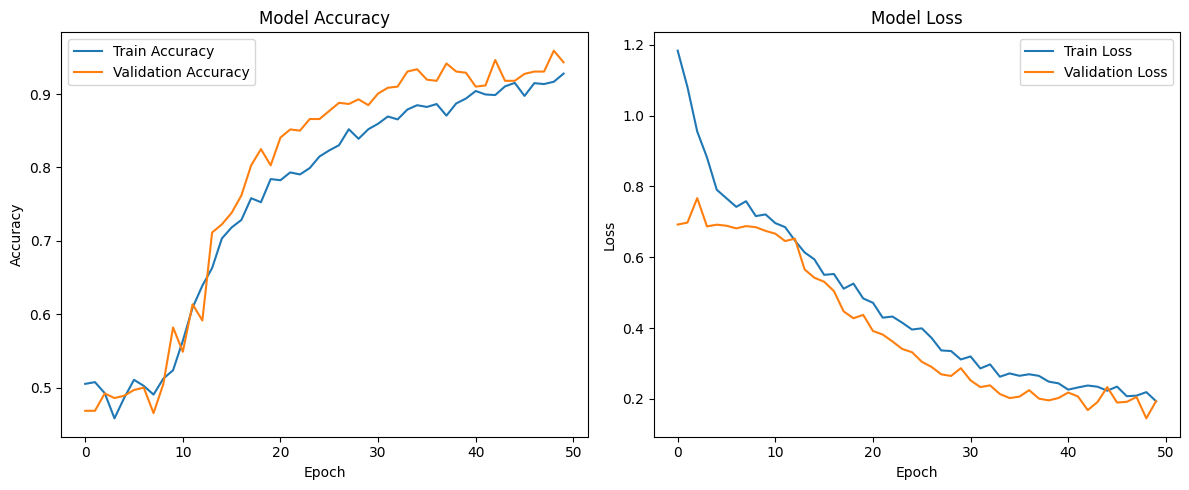

In [17]:
# Plot training & validation accuracy values
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='best')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='best')

plt.tight_layout()
plt.show()

In [18]:
# Evaluate the model on the validation set
val_loss, val_accuracy = model.evaluate(X_val, y_val)
print(f"Validation Loss: {val_loss}")
print(f"Validation Accuracy: {val_accuracy}")

20/20 [==============================] - 0s 719us/step - loss: 0.1938 - accuracy: 0.9432
Validation Loss: 0.19379693269729614
Validation Accuracy: 0.9432176947593689


*Training Accuracy:* **92.78%**

*Validation Accuracy:* **94.32%**

In [19]:
# Save the trained model
model.save('genderDetection02.h5')

**function to test our model**

In [40]:
import numpy as np
import librosa
from tensorflow.keras.models import load_model

# Function to extract features from an audio file
def extract_features(file_path):
    y, sr = librosa.load(file_path, sr=None)
    
    # Extracting the features
    features = {
        'meanfreq': np.mean(librosa.feature.spectral_centroid(y=y, sr=sr)),
        'sd': np.std(librosa.feature.spectral_centroid(y=y, sr=sr)),
        'median': np.median(librosa.feature.spectral_centroid(y=y, sr=sr)),
        'Q25': np.percentile(librosa.feature.spectral_centroid(y=y, sr=sr), 25),
        'Q75': np.percentile(librosa.feature.spectral_centroid(y=y, sr=sr), 75),
        'IQR': np.percentile(librosa.feature.spectral_centroid(y=y, sr=sr), 75) - np.percentile(librosa.feature.spectral_centroid(y=y, sr=sr), 25),
        'skew': np.mean(librosa.feature.spectral_bandwidth(y=y, sr=sr)),
        'kurt': np.std(librosa.feature.spectral_bandwidth(y=y, sr=sr)),
        'sp.ent': np.mean(librosa.feature.spectral_flatness(y=y)),
        'sfm': np.mean(librosa.feature.spectral_contrast(y=y, sr=sr)),
        'mode': np.median(librosa.feature.spectral_rolloff(y=y, sr=sr)),
        'centroid': np.mean(librosa.feature.spectral_centroid(y=y, sr=sr)),
        'meanfun': np.mean(librosa.feature.rms(y=y)),
        'minfun': np.min(librosa.feature.rms(y=y)),
        'maxfun': np.max(librosa.feature.rms(y=y)),
        'meandom': np.mean(librosa.feature.delta(y)),
        'mindom': np.min(librosa.feature.delta(y)),
        'maxdom': np.max(librosa.feature.delta(y)),
        'dfrange': np.max(librosa.feature.delta(y)) - np.min(librosa.feature.delta(y)),
        'modindx': np.std(librosa.feature.delta(y))
    }
    
    return np.array(list(features.values())).reshape(1, -1)

# Load the trained model
model = load_model('genderDetection02.h5')  # Replace with the actual path to your saved model

# Function to predict gender from an audio file
def predict_gender(file_path):
    features = extract_features(file_path)
    prediction = model.predict(features)
    print(prediction[0][0])
    return 'female' if prediction[0][0] >= 0.5 else 'male'

In [41]:
# Example usage
file_path = 'genderVoice/Male/1081_IEO_FEA_LO.wav'
gender = predict_gender(file_path)
print(f"The predicted gender is: {gender}")

1/1 [==============================] - 0s 76ms/step
1.0
The predicted gender is: female


In [42]:
gender = predict_gender("test_audio/where-are-you-104660.mp3")
print(f"The predicted gender is: {gender}")

1/1 [==============================] - 0s 21ms/step
0.0
The predicted gender is: male
